### Random forest workflow for BATS
# Code adapted from https://github.com/WillKoehrsen/Data-Analysis/blob/master/random_forest_explained/Random%20Forest%20Explained.ipynb
###



In [61]:
# Import packages
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
# import cPickle
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, matthews_corrcoef


In [33]:
# Import data
data = pd.read_csv('../data/training/sources/20230404_train/csv/20230404_training_sample.csv')

In [34]:
# Although data are mostly pre-processed, drop nan and convert to binary for classifier
data = data.dropna()
# Reclassify yolo training data to binary
data = data.replace({'class': {10: 0, 11:0, 12:0, 13:0}})

In [35]:
# Separate features and labels
labels = np.array(data['class'])

# Remove the labels from the data
features= data.drop('class', axis = 1)
features= features.drop('date', axis =1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

In [36]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25,
                                                                           random_state = 42)

In [37]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)



Training Features Shape: (23108, 6)
Training Labels Shape: (23108,)
Testing Features Shape: (7703, 6)
Testing Labels Shape: (7703,)


In [9]:
# Train Model
# Instantiate model 
rf = RandomForestClassifier(n_estimators= 1000, random_state=42)

# Train the model on training data
rf.fit(train_features, train_labels);

In [29]:
# Create our predictions
predictions = rf.predict(test_features)
# Create confusion matrix
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

print(confusion_matrix(test_labels, predictions))
# Display accuracy score
print("Accuracy: ", accuracy_score(test_labels, predictions))
# Display F1 score
print("F1 score: ", f1_score(test_labels,predictions))
# Display Precision
print("Precision: ", precision_score(test_labels,predictions))
# Display Recall
print("Recall: ", recall_score(test_labels,predictions))

[[5920   18]
 [  74 1691]]
Accuracy:  0.9880566013241594
F1 score:  0.9735175590097871
Precision:  0.9894675248683441
Recall:  0.9580736543909348


In [30]:
### Incorporate hyperparamter tuning
# First explore random hyperparameter grid and fine-tune with grid search with cross validation
###


In [33]:
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [34]:
# Train random rf grid
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_features, train_labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_estimators=1000,
                                                    random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [36]:
# Return the best paramters
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [49]:
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [31]:
def evaluate(model, test_features, test_labels):
    # Create our predictions
    predictions = model.predict(test_features)
    cm = confusion_matrix(test_labels, predictions)
    accuracy = accuracy_score(test_labels, predictions)
    f1 = f1_score(test_labels,predictions)
    precision = precision_score(test_labels,predictions)
    recall = recall_score(test_labels,predictions)
    auc = roc_auc_score(test_labels,predictions)
    prc = average_precision_score(test_labels,predictions)
    print('Model Performance')
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('AUC: ', auc)
    print('PRC: ', prc)
    return accuracy, precision, recall

In [38]:
best_random = rf_random.best_estimator_
random_metrics = evaluate(best_random, test_features, test_labels)

Model Performance
Accuracy:  0.9881864208749838
Precision:  0.9900468384074942
Recall:  0.9580736543909348


In [43]:
# RF Gridsearch

from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 4, 6],
    'n_estimators': [1200, 1400, 1600]
}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [44]:
# Fit the grid search to the data
grid_search.fit(train_features, train_labels)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [1200, 1400, 1600]},
             verbose=2)

In [45]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, test_features, test_labels)

Model Performance
Accuracy:  0.9877969622225107
Precision:  0.9888823873610298
Recall:  0.9575070821529745


In [50]:
best_random

RandomForestClassifier(max_depth=100, n_estimators=1400, random_state=42)

In [4]:
import joblib

In [53]:
# save
joblib.dump(best_random, "../data/doppler/models/20230405_rf_opt/my_random_forest.joblib")



['../data/doppler/models/20230405_rf_opt/my_random_forest.joblib']

In [9]:
os.getcwd()

'/Users/brianlee/Desktop/new_bats/scripts'

In [11]:
# load
loaded_rf = joblib.load("../data/doppler/models/20230405_models/rf/best_rf.joblib")

/Users/brianlee/opt/anaconda3/envs/doppler/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/brianlee/opt/anaconda3/envs/doppler/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [12]:
loaded_rf

RandomForestClassifier(max_depth=100, max_features='auto', n_estimators=1400,
                       random_state=42)

In [17]:
valid_data = pd.read_csv('/Users/brianlee/Desktop/new_bats/data/training/sources/validation_data/tx/validation_data/combined_validation_data.csv')
valid_data = valid_data.drop('date', axis=1)

In [18]:
valid_data

,cor,pha,dif,ref,spw,vel,training_class
0,0.998333,346.60272,6.9375,-1.5,1.5,9.5,0.0
1,0.811667,286.30865,7.9375,-4.0,1.5,9.5,0.0
2,0.811667,286.30865,7.9375,-4.0,1.0,10.0,0.0
3,1.051667,103.31088,7.9375,-4.5,1.0,10.0,0.0
4,1.051667,103.31088,7.9375,-4.5,2.0,9.0,0.0
...,...,...,...,...,...,...,...
259813,1.051667,137.86537,5.6250,-4.5,0.0,24.5,0.0
259814,0.705000,146.32770,1.5000,-4.5,1.0,6.5,0.0
259815,0.978333,125.52448,7.9375,5.0,1.0,6.5,0.0
259816,0.978333,125.52448,7.9375,-2.0,2.5,5.0,0.0


In [19]:
# Form np arrays of labels and features.
val_labels2 = np.array(valid_data.pop('training_class'))

variables = ['cor', 'pha', 'dif', 'ref', 'spw', 'vel']

val_features2 = np.array(valid_data[variables])

# val_features2_norm=normalizer(val_features2)

In [32]:
random_metrics = evaluate(loaded_rf, val_features2, val_labels2)

Model Performance
Accuracy:  0.9474478288648207
Precision:  0.8784393681460073
Recall:  0.8552129504721526
AUC:  0.912839344306139
PRC:  0.7801691191659202


In [39]:
# Evaluate metrics
train_predictions_baseline2 = loaded_rf.predict(train_features)
test_predictions_baseline2 = loaded_rf.predict(val_features2)



# def plot_cm(labels, predictions, p=0.5):
#     cm = confusion_matrix(labels, predictions > p)
#     plt.figure(figsize=(5,5))
#     sns.heatmap(cm, annot=True, fmt="d")
#     plt.title('Confusion matrix @{:.2f}'.format(p))
#     plt.ylabel('Actual label')
#     plt.xlabel('Predicted label')

#     print('No bats (True Negatives): ', cm[0][0])
#     print('Bats Incorrectly Detected (False Positives): ', cm[0][1])
#     print('Bats Missed (False Negatives): ', cm[1][0])
#     print('Bats Detected (True Positives): ', cm[1][1])
#     print('Total bat occurrence: ', np.sum(cm[1]))

# baseline_results = loaded_rf.evaluate(val_features2, val_labels2,
#                                   batch_size=32, verbose=0)
# for name, value in zip(model.metrics_names, baseline_results):
#     print(name, ': ', value)
# print()

# plot_cm(val_labels2, val_features2)

In [52]:
import matplotlib as mpl

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rcParams['figure.figsize'] = (12, 10)


In [62]:
mcc = matthews_corrcoef(val_labels2, test_predictions_baseline2)

In [63]:
mcc

0.8340684820230468

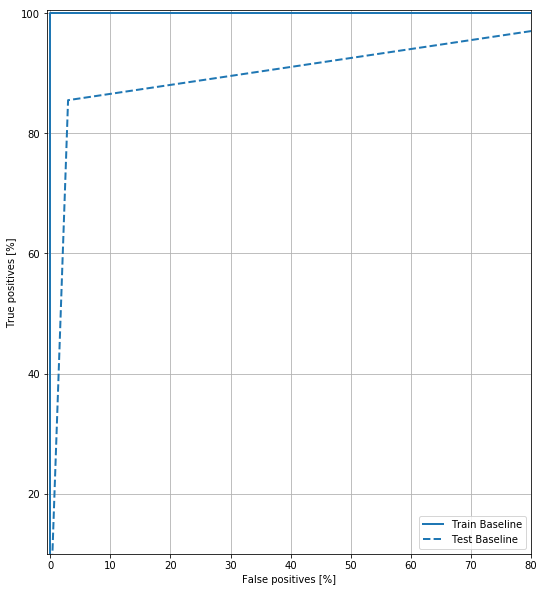

In [53]:
# Plot the ROC
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,80])
    plt.ylim([10,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')


plot_roc("Train Baseline", train_labels, train_predictions_baseline2, color=colors[0])
plot_roc("Test Baseline", val_labels2, test_predictions_baseline2, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

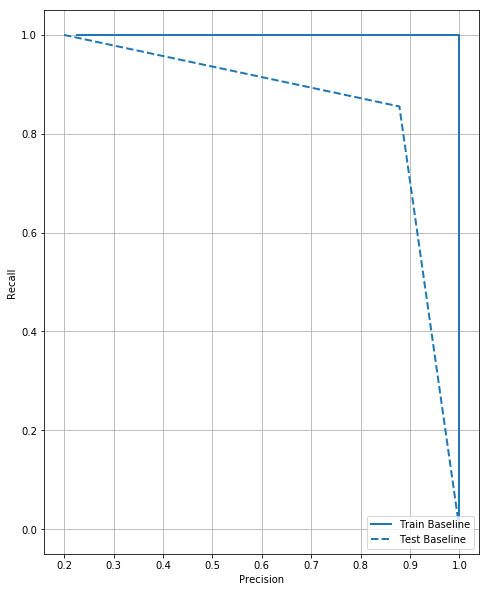

In [60]:
# Plot the AUPRC
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

mpl.rcParams['figure.figsize'] = (12, 10)

plot_prc("Train Baseline", train_labels, train_predictions_baseline2, color=colors[0])
plot_prc("Test Baseline", val_labels2, test_predictions_baseline2, color=colors[0], linestyle='--')
plt.legend(loc='lower right');